# Analyse Connections

Some plots and analyses on raw Cicero output.

In [ ]:
library(cicero)
library(Matrix)
library(ggplot2)
library(scales)
library(GenomicFeatures)
library(reshape2)

In [2]:
gz = "./out/20200417_default_20200220_n74838/coaccess.gt0.3.tsv.gz"
high_conns = read.table(gz, header=F, sep='\t')
colnames(high_conns) = c("Peak1", "Peak2", "coaccess")
high_conns$distance = abs(as.integer(lapply(strsplit(as.character(high_conns$Peak1), "_"), "[[", 2)) - as.integer(lapply(strsplit(as.character(high_conns$Peak2), "_"), "[[", 2)))
min(high_conns$coaccess)
dim(high_conns)
head(high_conns)

[1] 0.3000008

[1] 585102      4

,Peak1,Peak2,coaccess,distance
,<fct>,<fct>,<dbl>,<int>
1,chr10_100006055_100006360,chr10_99779363_99780088,0.3004101,226692
2,chr10_100006055_100006360,chr10_99906257_99907164,0.3203871,99798
3,chr10_100006055_100006360,chr10_99976944_99977384,0.3607012,29111
4,chr10_100006055_100006360,chr10_99983204_99984691,0.3491921,22851
5,chr10_100006055_100006360,chr10_99994339_99994936,0.3309449,11716
6,chr10_100006055_100006360,chr10_100006376_100006866,0.6237400,321


## Prepare Promoters

In [ ]:
txdb = makeTxDbFromGFF("/users/surag/kundajelab/scATAC-reprog/resources/refGene/hg38.refGene.gtf.gz", format="gtf")

In [4]:
tx.hg38 = transcripts(txdb, columns = c("gene_id", "tx_name"))
tx.hg38$gene_id = unlist(tx.hg38$gene_id)
tss.hg38 = unique(resize(tx.hg38, width=1, fix='start'))
tss.hg38

GRanges object with 46236 ranges and 2 metadata columns:
                  seqnames    ranges strand |      gene_id      tx_name
                     <Rle> <IRanges>  <Rle> |  <character>  <character>
      [1]             chr1     11874      + |      DDX11L1    NR_046018
      [2]             chr1     30366      + |    MIR1302-2    NR_036051
      [3]             chr1     69091      + |        OR4F5 NM_001005484
      [4]             chr1    182388      + | LOC102725121    NR_148357
      [5]             chr1    817371      + |       FAM87B    NR_103536
      ...              ...       ...    ... .          ...          ...
  [46232] chrUn_GL000220v1    155996      + |    RNA5-8SN5    NR_003285
  [46233] chrUn_GL000220v1    155997      + |    RNA5-8SN4  NR_146120_8
  [46234] chrUn_GL000224v1    102503      + | LOC100505874    NR_135481
  [46235] chrUn_KI270741v1     44381      + | LOC100505874  NR_135481_2
  [46236] chrUn_KI270753v1     59598      - | LOC105379514  NR_135513_2
  -----

In [5]:
prom.hg38 = promoters(tss.hg38, upstream = 2000, downstream = 500)
prom.hg38

GRanges object with 46236 ranges and 2 metadata columns:
                  seqnames        ranges strand |      gene_id      tx_name
                     <Rle>     <IRanges>  <Rle> |  <character>  <character>
      [1]             chr1    9874-12373      + |      DDX11L1    NR_046018
      [2]             chr1   28366-30865      + |    MIR1302-2    NR_036051
      [3]             chr1   67091-69590      + |        OR4F5 NM_001005484
      [4]             chr1 180388-182887      + | LOC102725121    NR_148357
      [5]             chr1 815371-817870      + |       FAM87B    NR_103536
      ...              ...           ...    ... .          ...          ...
  [46232] chrUn_GL000220v1 153996-156495      + |    RNA5-8SN5    NR_003285
  [46233] chrUn_GL000220v1 153997-156496      + |    RNA5-8SN4  NR_146120_8
  [46234] chrUn_GL000224v1 100503-103002      + | LOC100505874    NR_135481
  [46235] chrUn_KI270741v1   42381-44880      + | LOC100505874  NR_135481_2
  [46236] chrUn_KI270753v1   59

In [57]:
# load bulk RNA-seq data
fpkm = read.table("/users/surag/kundajelab/scATAC-reprog/resources/GSE62777/RNAseq.FPKM.tsv", sep='\t', header=T)
fpkm$gene_id = NULL
fpkm$locus=NULL
tpm = fpkm
tpm[,2:ncol(tpm)] = 1e6*t(t(tpm[,2:ncol(tpm)])/colSums(tpm[,2:ncol(tpm)]))

# removing genes with dup names
tpm = tpm[!duplicated(tpm$gene_short_name),]
rownames(tpm) = tpm$gene_short_name
tpm$gene_short_name = NULL

tpm["GAPDH",]

,hiF.T_P14,X2dd_DOX_plus,X5dd_DOX_plus,X8dd_DOX_plus,X10dd_DOX_plus_SSEA3_pos,X14dd_DOX_plus_SSEA3_pos,X20dd_DOX_plus_TRA_plus,X24dd_TRA_pos_DOX_plus,X24dd_TRA_pos_DOX_minus,hIPSC.T_P10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GAPDH,7803.64,4963.505,3908.693,3839.776,3795.548,3364.503,3032.412,3790.955,5598.224,4731.256


## Visualize

In [4]:
gene_anno <- rtracklayer::readGFF("/users/surag/kundajelab/scATAC-reprog/resources/refGene/hg38.refGene.gtf.gz")
gene_anno = gene_anno[!is.na(gene_anno$exon_number), ]


# rename some columns to match requirements
gene_anno$chromosome <-  gene_anno$seqid
gene_anno$gene <- gene_anno$gene_id
gene_anno$transcript <- gene_anno$transcript_id
gene_anno$symbol <- gene_anno$gene_name

In [6]:
dim(gene_anno)

[1] 1809073      17

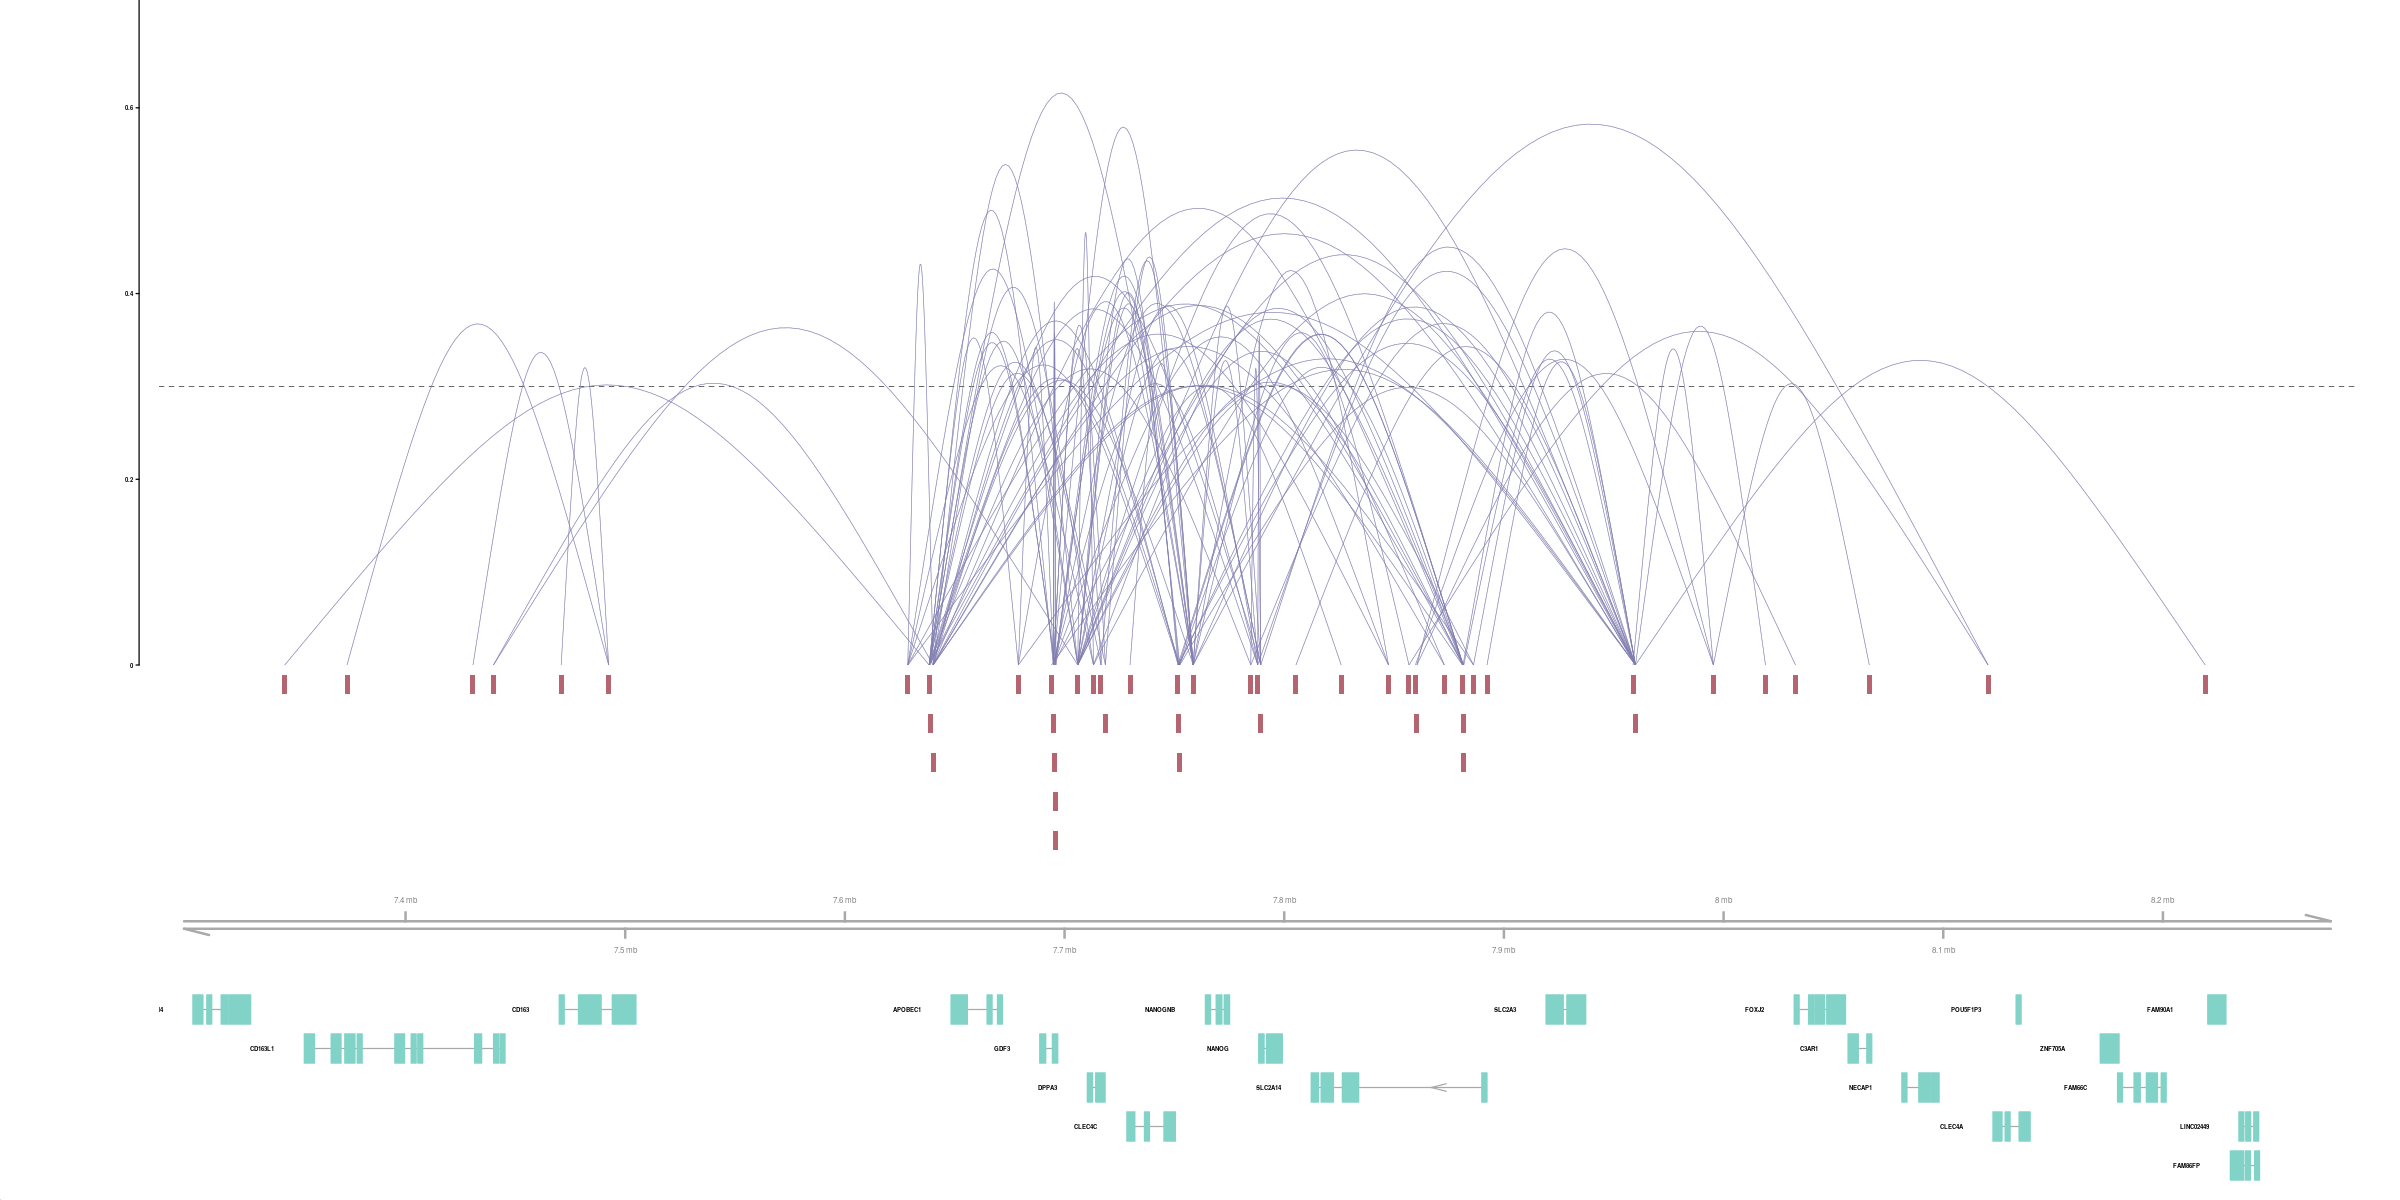

In [276]:
options(repr.plot.width = 20, repr.plot.height = 10)

plot_connections(high_conns[high_conns$distance>1000,], "chr12", 7287794, 8287794,
                 gene_model = gene_anno, 
                 coaccess_cutoff = .3, 
                 connection_width = .5, 
                 collapseTranscripts = "longest" )

## Plots

In [6]:
peaks_left = sub("_", "-", sub("_", ":", high_conns$Peak1))
peaks_right = sub("_", "-", sub("_", ":", high_conns$Peak2))
head(peaks_left)
head(peaks_right)

[1] "chr10:100006055-100006360" "chr10:100006055-100006360"
[3] "chr10:100006055-100006360" "chr10:100006055-100006360"
[5] "chr10:100006055-100006360" "chr10:100006055-100006360"

[1] "chr10:99779363-99780088"   "chr10:99906257-99907164"  
[3] "chr10:99976944-99977384"   "chr10:99983204-99984691"  
[5] "chr10:99994339-99994936"   "chr10:100006376-100006866"

In [7]:
# looks like each connection is entered twice
all(sort(peaks_left)==sort(peaks_right))

[1] TRUE

In [8]:
peaks_left_is_gene = seq(1,length(peaks_left)) %in% queryHits(findOverlaps(GRanges(peaks_left), prom.hg38))
peaks_right_is_gene = seq(1,length(peaks_right)) %in% queryHits(findOverlaps(GRanges(peaks_right), prom.hg38))
sum(peaks_left_is_gene)
sum(peaks_right_is_gene)

[1] 58304

[1] 58304

In [18]:
# for the following plots, take only links with distance > DIST_THRESH
# nearby links may just be artefacts of binning strategies
DIST_THRESH = 2000

In [19]:
frac_prom = sum((peaks_left_is_gene)&(high_conns$distance>DIST_THRESH))/sum(high_conns$distance>DIST_THRESH)

print(sprintf("Frac Prom     : %.4f", frac_prom*100))
print(sprintf("Exp Prom-Prom : %.4f", frac_prom**2*100))
print(sprintf("Exp Enh-Enh   : %.4f", (1-frac_prom)**2*100))
print(sprintf("Exp Enh-Prom  : %.4f", (1-frac_prom)*2*frac_prom*100))

[1] "Frac Prom     : 8.6706"
[1] "Exp Prom-Prom : 0.7518"
[1] "Exp Enh-Enh   : 83.4106"
[1] "Exp Enh-Prom  : 15.8376"


In [20]:
# each edge is entered twice, so actual numbers are halved but fractions stay the same
enh_enh = sum((!peaks_left_is_gene)&(!peaks_right_is_gene)&(high_conns$distance>DIST_THRESH))/sum(high_conns$distance>DIST_THRESH)
prom_prom = sum((peaks_left_is_gene)&(peaks_right_is_gene)&(high_conns$distance>DIST_THRESH))/sum(high_conns$distance>DIST_THRESH)
prom_enh = 1 - prom_prom - enh_enh

print(sprintf("Obs Prom-Prom : %.4f", prom_prom*100))
print(sprintf("Obs Enh-Enh   : %.4f", enh_enh*100))
print(sprintf("Obs Enh-Prom  : %.4f", prom_enh*100))

[1] "Obs Prom-Prom : 1.6100"
[1] "Obs Enh-Enh   : 84.2688"
[1] "Obs Enh-Prom  : 14.1211"


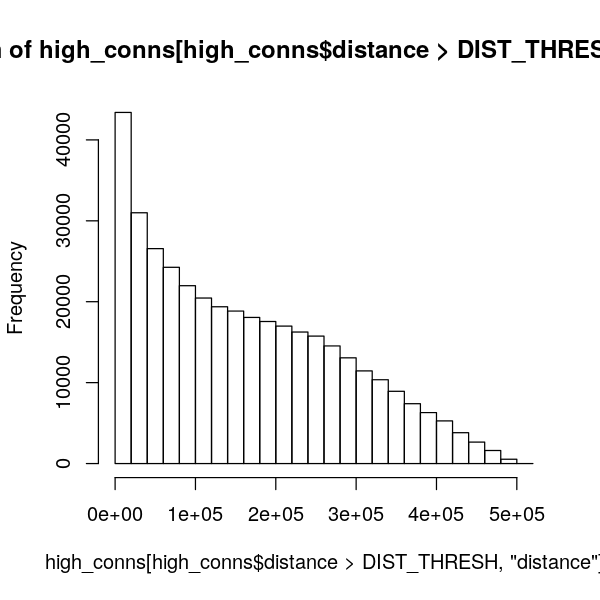

In [46]:
options(repr.plot.width = 5, repr.plot.height = 5)
hist(high_conns[high_conns$distance>DIST_THRESH,"distance"])

In [33]:
# degree
freqs = table(high_conns[high_conns$distance>DIST_THRESH,]$Peak1)
freqs = freqs[freqs>0]
quantile(freqs, c(0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1))

  0%  25%  50%  75%  90%  95%  99% 100% 
   1    1    3    6   12   17   29   88 

In [36]:
# degree - proms
freqs = table(high_conns[(high_conns$distance>DIST_THRESH)&(peaks_left_is_gene),]$Peak1)
freqs = freqs[freqs>0]
quantile(freqs, c(0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1))

  0%  25%  50%  75%  90%  95%  99% 100% 
   1    1    3    6   11   16   27   79 

In [35]:
# degree - enhs
freqs = table(high_conns[(high_conns$distance>DIST_THRESH)&(!peaks_left_is_gene),]$Peak1)
freqs = freqs[freqs>0]
quantile(freqs, c(0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1))

  0%  25%  50%  75%  90%  95%  99% 100% 
   1    1    3    6   12   17   29   88 

In [37]:
rev(sort(table(high_conns[(high_conns$distance>DIST_THRESH)&(!peaks_left_is_gene),]$Peak1)))[1:10]


chr2_237456131_237456911 chr2_237280001_237280626 chr2_237669611_237670449 
                      88                       85                       80 
chr2_237465577_237466698 chr2_237290899_237291772 chr2_237440982_237442148 
                      80                       78                       75 
chr2_237687601_237688117 chr2_237500413_237501298  chr15_66883258_66884102 
                      73                       71                       69 
chr2_237128051_237128606 
                      67 

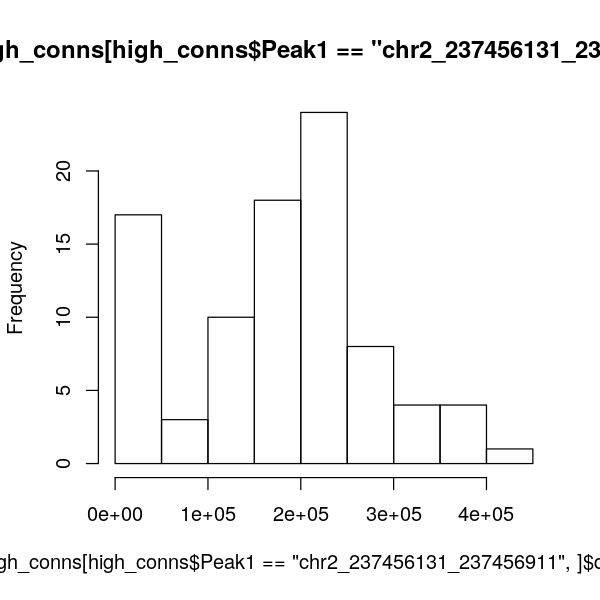

In [45]:
options(repr.plot.width = 5, repr.plot.height = 5)
hist(high_conns[high_conns$Peak1=="chr2_237456131_237456911",]$distance)

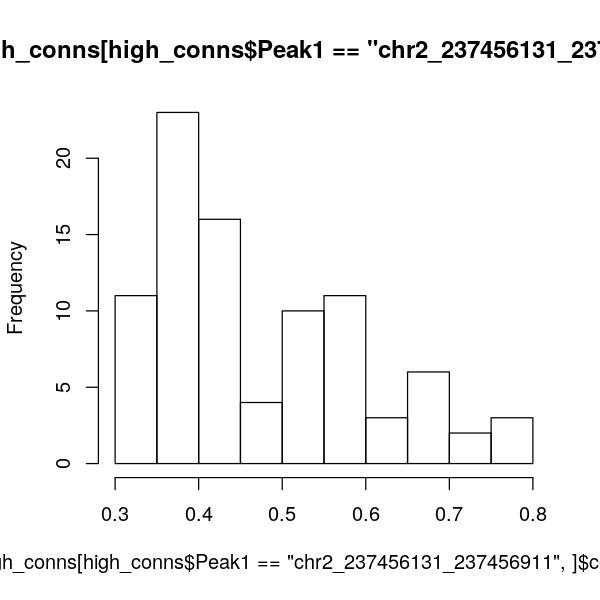

In [44]:
options(repr.plot.width = 5, repr.plot.height = 5)
hist(high_conns[high_conns$Peak1=="chr2_237456131_237456911",]$coaccess)

## Enhancer-gene contacts

In [246]:
# subset to those with RNA
subset.prom.hg38 = prom.hg38[prom.hg38$gene_id %in% rownames(tpm)]

peaks_left_is_gene = seq(1,length(peaks_left)) %in% queryHits(findOverlaps(GRanges(peaks_left), subset.prom.hg38))
peaks_right_is_gene = seq(1,length(peaks_right)) %in% queryHits(findOverlaps(GRanges(peaks_right), subset.prom.hg38))
sum(peaks_left_is_gene)
sum(peaks_right_is_gene)

[1] 47375

[1] 47375

In [247]:
# find enhancer/non-promoter -> gene links such that enhancer belongs to set
# can look from left to right only since each link is repeated twice 
enhancer_to_gene_link = ((!peaks_left_is_gene)&(peaks_right_is_gene)&(high_conns$distance>DIST_THRESH))
e2g_overlaps = findOverlaps(GRanges(peaks_right[enhancer_to_gene_link]), subset.prom.hg38)
e2g_enhs = peaks_left[enhancer_to_gene_link][queryHits(e2g_overlaps)] # these are the enhancers that link to gene
e2g_genes = subset.prom.hg38[subjectHits(e2g_overlaps)]$gene_id
e2g_uniq = unique(data.frame(e=e2g_enhs, g=e2g_genes)) # uniquify e-g link

sum(enhancer_to_gene_link)
length(unique(e2g_uniq$g))

[1] 21564

[1] 4007

In [248]:
rev(sort(table(e2g_uniq$e)))[1:20]


chr7:100965383-100966966  chr11:65915704-65916037   chr3:52237582-52237816 
                      16                       14                       11 
   chr17:7404012-7404991   chr1:28972084-28972775 chr8:144014599-144015077 
                      11                       11                       10 
chr7:100835864-100837825 chr2:241680687-241681503  chr19:13846541-13848028 
                      10                       10                       10 
   chr17:7841632-7843181    chr17:7587400-7587716  chr11:65290567-65291124 
                      10                       10                       10 
  chr1:28601723-28602170     chr1:1264787-1265600 chr7:101232178-101232760 
                      10                       10                        9 
 chr22:37663568-37664100  chr22:37633393-37634562  chr19:48737461-48737683 
                       9                        9                        9 
 chr19:48501471-48502527  chr19:13851159-13851743 
                       9            

In [249]:
options(repr.plot.width = 5, repr.plot.height = 5)
quantile(table(e2g_uniq$g), c(0, 0.25, 0.5, 0.75, 0.9, 0.95, 1))
length(table(e2g_uniq$e))

  0%  25%  50%  75%  90%  95% 100% 
   1    1    3    6   11   16   78 

[1] 13349

In [250]:
rev(sort(table(e2g_uniq$g)))[1:10]


 COL6A3   FOXF1   SMAD3   FOXL1 MICALCL  MICAL2   NDST1 C8orf86   IL17B  SPINT2 
     78      66      58      58      52      48      47      47      46      44 

In [251]:
subset(e2g_uniq, e=="chr7:100965383-100966966")

,e,g
,<fct>,<fct>
25226,chr7:100965383-100966966,SAP25
25227,chr7:100965383-100966966,FBXO24
25228,chr7:100965383-100966966,LRCH4
25231,chr7:100965383-100966966,TFR2
25232,chr7:100965383-100966966,ACTL6B
25233,chr7:100965383-100966966,GIGYF1
25234,chr7:100965383-100966966,SLC12A9
25236,chr7:100965383-100966966,EPHB4
25237,chr7:100965383-100966966,ACHE


[1] 16

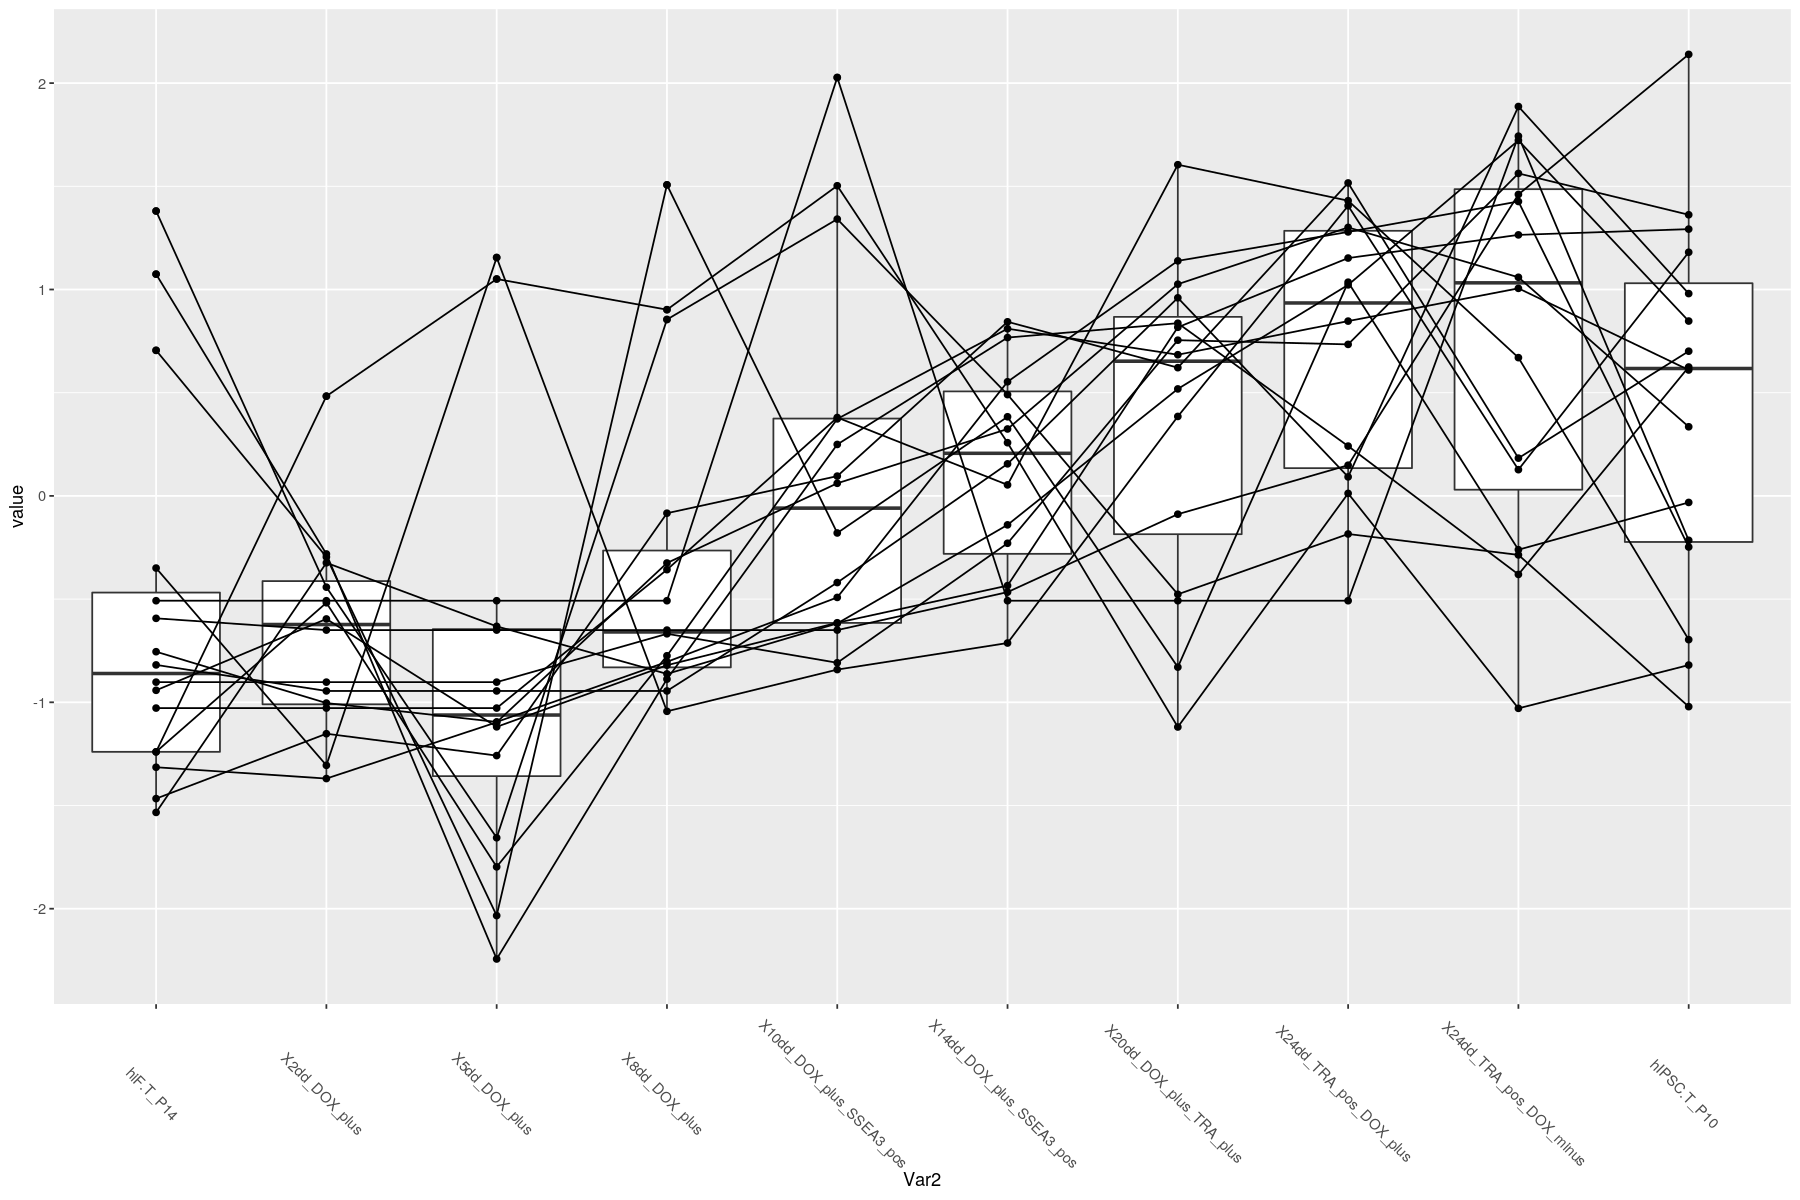

In [252]:
options(repr.plot.width = 15, repr.plot.height = 10)

gene_subset = subset(e2g_uniq, e=="chr7:100965383-100966966")$g
sum(rownames(tpm) %in% gene_subset)
# ggplot(melt(as.matrix(log2(1+tpm)[rownames(tpm) %in% gene_subset, ])), aes(x=Var2, y=value)) +
ggplot(melt(t(scale(t(log2(1+tpm)[rownames(tpm) %in% gene_subset, ])))), aes(x=Var2, y=value)) +
stat_boxplot() +
geom_line(aes(group=Var1)) +
geom_point() + 
theme(axis.text.x = element_text(angle = -45))
# geom_boxplot(outlier.shape = NA) + geom_jitter(width = 0.2)
# coord_cartesian(ylim=c(0,8)) 

In [270]:
# for pairs of genes co-accessible with an enhancer and randomly chosen, direction of change from hiF -> hiPSC
NUM_PAIRS = 10000

e2g_uniq_e_table_gt1 = names(table(e2g_uniq$e)[table(e2g_uniq$e)>1])
coaccs_gene_pairs = list()
for (i in seq(NUM_PAIRS)) {    
    # choose an enhancer with >1 genes
    coaccs_gene_pairs[[i]] = as.character(sample(subset(e2g_uniq, e==sample(e2g_uniq_e_table_gt1, 1))$g, 2))
}

In [271]:
rand_gene_pairs = list()
e2g_uniq_genes = unique(e2g_uniq$g)
for (i in seq(NUM_PAIRS)) {    
    # choose an enhancer with >1 genes
    rand_gene_pairs[[i]] = as.character(sample(e2g_uniq_genes, 2))
}

In [279]:
pair_set = coaccs_gene_pairs
g1 = unlist(lapply(pair_set, "[[", 1))
g2 = unlist(lapply(pair_set, "[[", 2))
coaccs_both_up = 100*sum(((tpm[g1, "hiF.T_P14"]-tpm[g1, "hIPSC.T_P10"]>0)&(tpm[g2, "hiF.T_P14"]-tpm[g2, "X14dd_DOX_plus_SSEA3_pos"])>0))/NUM_PAIRS
coaccs_both_down = 100*sum(((tpm[g1, "hiF.T_P14"]-tpm[g1, "hIPSC.T_P10"]<0)&(tpm[g2, "hiF.T_P14"]-tpm[g2, "X14dd_DOX_plus_SSEA3_pos"])<0))/NUM_PAIRS

pair_set = rand_gene_pairs
g1 = unlist(lapply(pair_set, "[[", 1))
g2 = unlist(lapply(pair_set, "[[", 2))
rand_both_up = 100*sum(((tpm[g1, "hiF.T_P14"]-tpm[g1, "hIPSC.T_P10"]>0)&(tpm[g2, "hiF.T_P14"]-tpm[g2, "X14dd_DOX_plus_SSEA3_pos"])>0))/NUM_PAIRS
rand_both_down = 100*sum(((tpm[g1, "hiF.T_P14"]-tpm[g1, "hIPSC.T_P10"]<0)&(tpm[g2, "hiF.T_P14"]-tpm[g2, "X14dd_DOX_plus_SSEA3_pos"])<0))/NUM_PAIRS

In [283]:
df = data.frame(c(coaccs_both_up, coaccs_both_down, 100-coaccs_both_up-coaccs_both_down, 
                  rand_both_up, rand_both_down, 100-rand_both_up-rand_both_down))
rownames(df) = c("Coaccs Both Up", "Coaccs Both Down", "Coaccs Opposite", "Random Both Up", "Random Both Down", "Random Opposite")
colnames(df) = c("Percentage")
df$label = rownames(df)

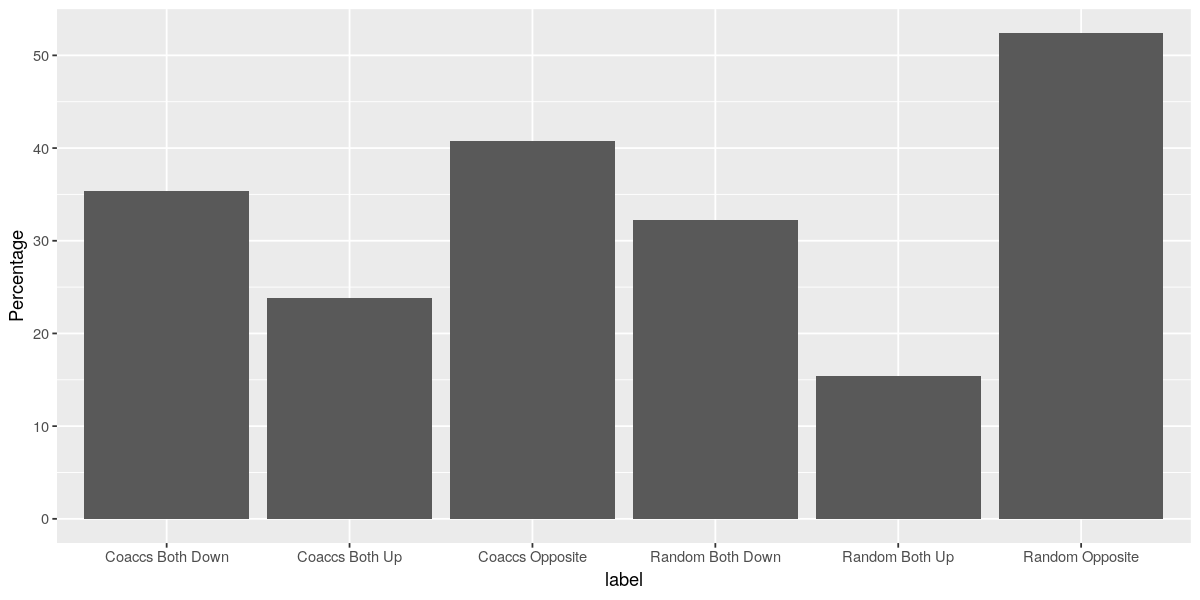

In [285]:
options(repr.plot.width = 10, repr.plot.height = 5)
ggplot(df, aes(x=label, y=Percentage)) +
geom_bar(stat="identity")